# Exploring Wave Spectra Variables from the Spotter Archive

See [Spotter Technical Manual](https://content.sofarocean.com/hubfs/Spotter%20product%20documentation%20page/Sofar%20-%20Technical_Reference_Manual.pdf) for details on wave spectra from directional wave buoys like Spotter.

This notebook demonstrates plotting from zarr stored on S3:

1. For a specific Spotter, the variance density (e(f)) colored by time.
2. For a specific Spotter, the variance density (e(f)) colored by H$_s$.

All data access methods remain the same if using the netCDF file downloaded locally, e.g., `ds = xr.load_dataset(local_filename)`. The xarray + zarr allows for efficient remote access of the data without full download, but does require internet connection.

In [1]:
# Import necessary packages (you may need to pip install in your environment)

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import cartopy.crs as ccrs # for mapping
import xarray as xr
import datetime

import numpy as np

import s3fs


## Load netcdf dataset
xarray is used to load dataset

In [2]:
# open the file using xarray and zarr

s3_uri = "s3://sofar-spotter-archive/spotter_data_spectra/"

s3 = s3fs.S3FileSystem(anon=True)
store = s3fs.S3Map(root=s3_uri, s3=s3, check=False)
ds = xr.open_zarr(store=store, consolidated=True)
# ds

## Plot variance density (1D spectrum) colored by time

Drifter index for SPOT-0164 is 0


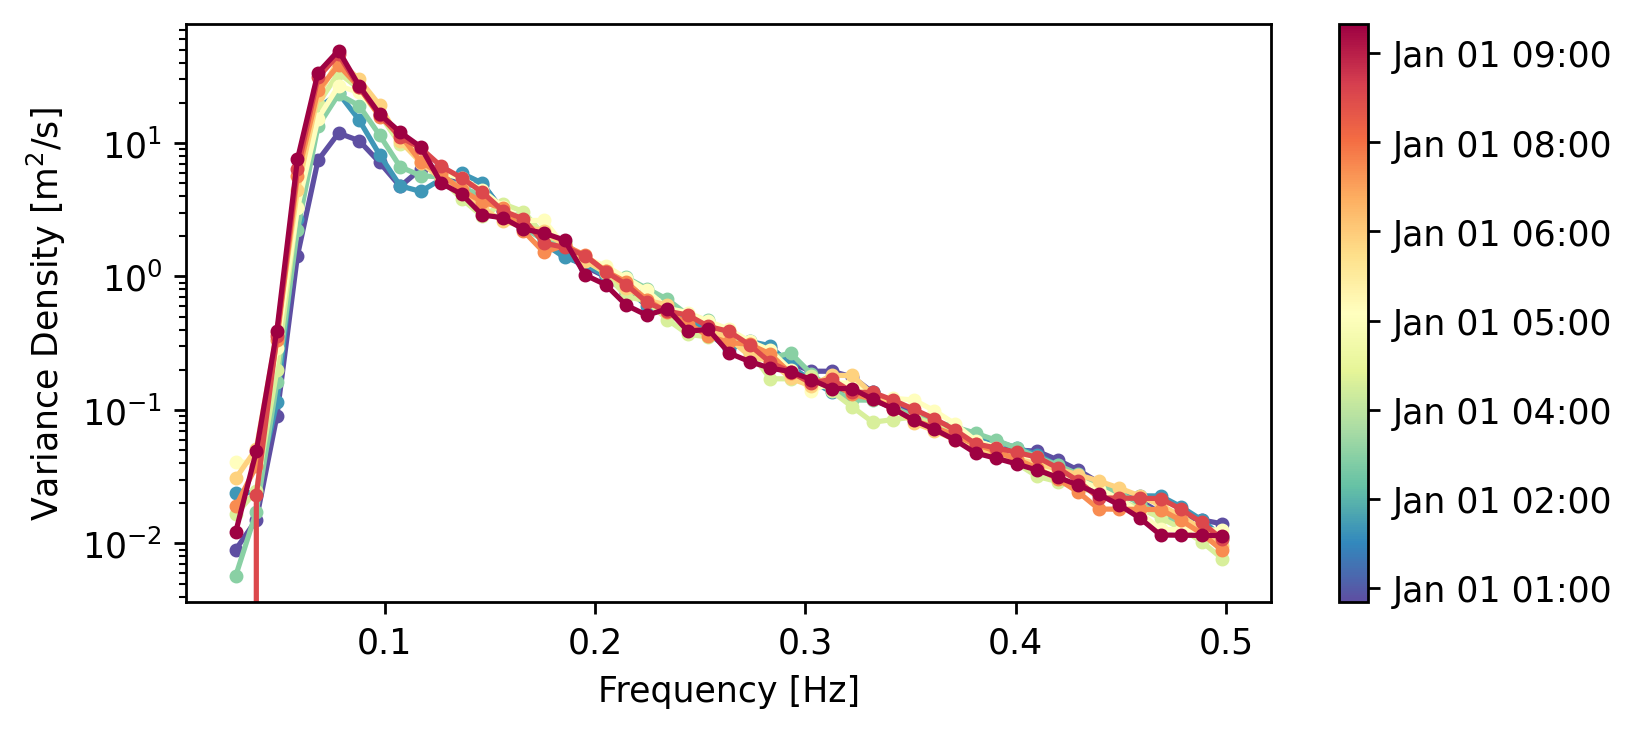

In [3]:
# chose a drifter by ID
spotter_id = 'SPOT-0164'
target_time_start = np.datetime64('2022-01-01T00:00')
target_time_end = np.datetime64('2022-01-02T00:00')


# create array that points to indices for each trajectory (and insert 0 index at beginning of array)
traj_idx = np.insert(np.cumsum(ds.rowsize.values), 0, 0)


# find index of chosen drifter
j = np.where(ds.trajectory==spotter_id)[0][0]
print(f"Drifter index for {spotter_id} is {j}")


# create the slice index `sli` for data from that drifter
sli = slice(traj_idx[j], traj_idx[j+1])


selected_ds = ds.sel(index=sli)
selected_ds =  selected_ds.where((selected_ds.time>target_time_start)&(selected_ds.time<target_time_end), drop=True)


color_list = cm.Spectral_r(np.linspace(0, 1, len(selected_ds)))


fig = plt.figure(figsize=(7,3), dpi=250)
ax = fig.add_subplot(1,1,1)

for ind, color in enumerate(color_list):
    ax.plot(selected_ds.frequency,
            selected_ds.variance_density[ind, :],
            marker='.', 
            c=color)
    
ax.set(xlabel="Frequency [Hz]", ylabel="Variance Density [m$^2$/s]")
ax.set_yscale('log')

sm = cm.ScalarMappable(cmap="Spectral_r", 
                       norm=plt.Normalize(vmin=selected_ds.time.min(),
                                              vmax=selected_ds.time.max()))

cbar = plt.colorbar(sm, ax=ax)
vals = cbar.ax.get_yticks()[1:-1]
cbar.ax.yaxis.set_ticks(vals)

# Change the numeric ticks into ones that match the x-axis
cbar.ax.set_yticklabels(pd.to_datetime(vals).strftime(date_format='%b %d %H:00'))


plt.show()


## Plot variance density (1D spectrum) colored by H$_s$

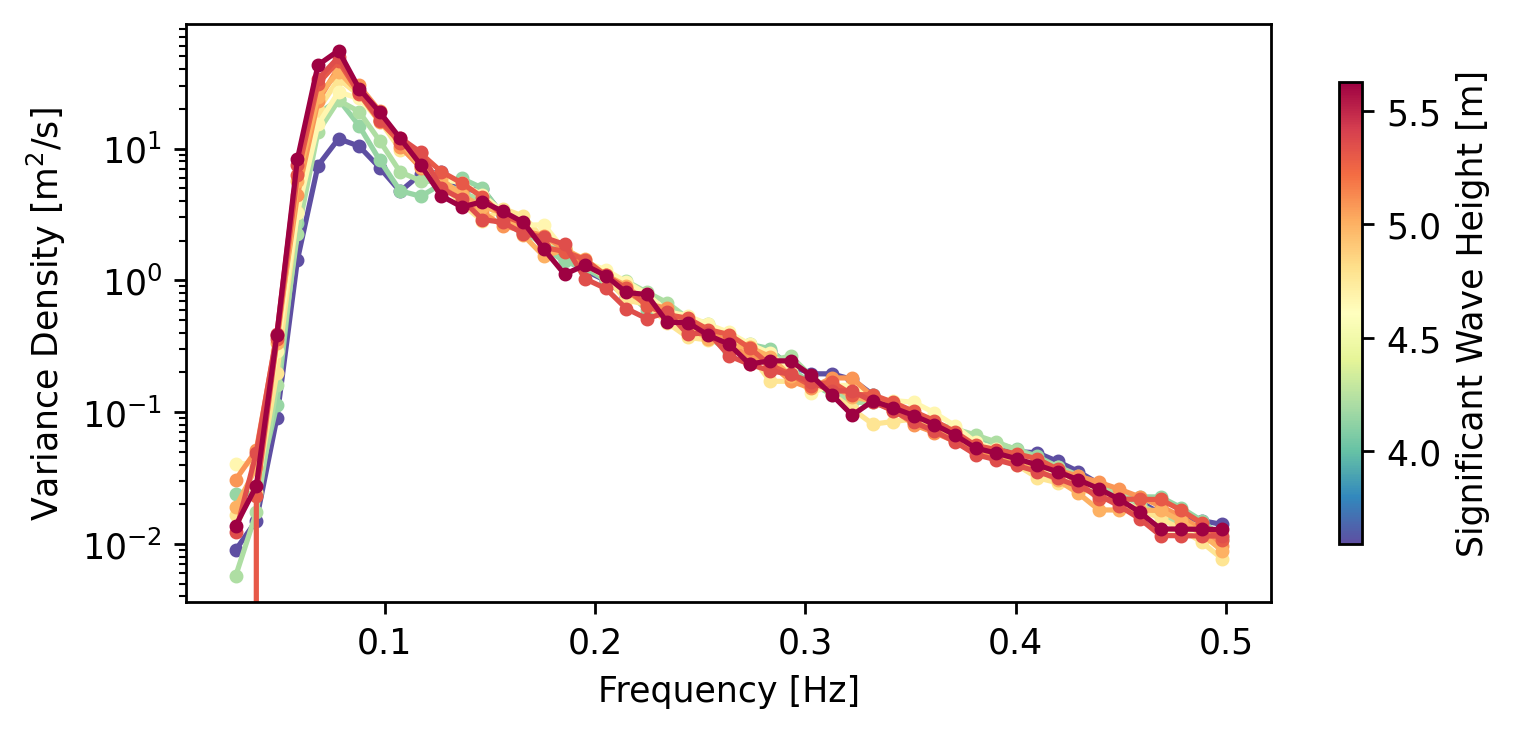

In [4]:
fig = plt.figure(figsize=(7,3), dpi=250)
ax = fig.add_subplot(1,1,1)

hs = selected_ds.significant_waveheight

for ind in range(len(hs)):
    color_float = (hs[ind].values-hs.min())/(hs.max()-hs.min())
    ax.plot(selected_ds.frequency,
            selected_ds.variance_density[ind, :],
            marker='.', 
            c=cm.Spectral_r(color_float))
    
ax.set(xlabel="Frequency [Hz]", ylabel="Variance Density [m$^2$/s]")
ax.set_yscale('log')

sm = cm.ScalarMappable(cmap="Spectral_r", 
                       norm=plt.Normalize(vmin=selected_ds.significant_waveheight.min(),
                                              vmax=selected_ds.significant_waveheight.max()))

cbar = plt.colorbar(sm, ax=ax, label='Significant Wave Height [m]', shrink=0.8)

plt.show()


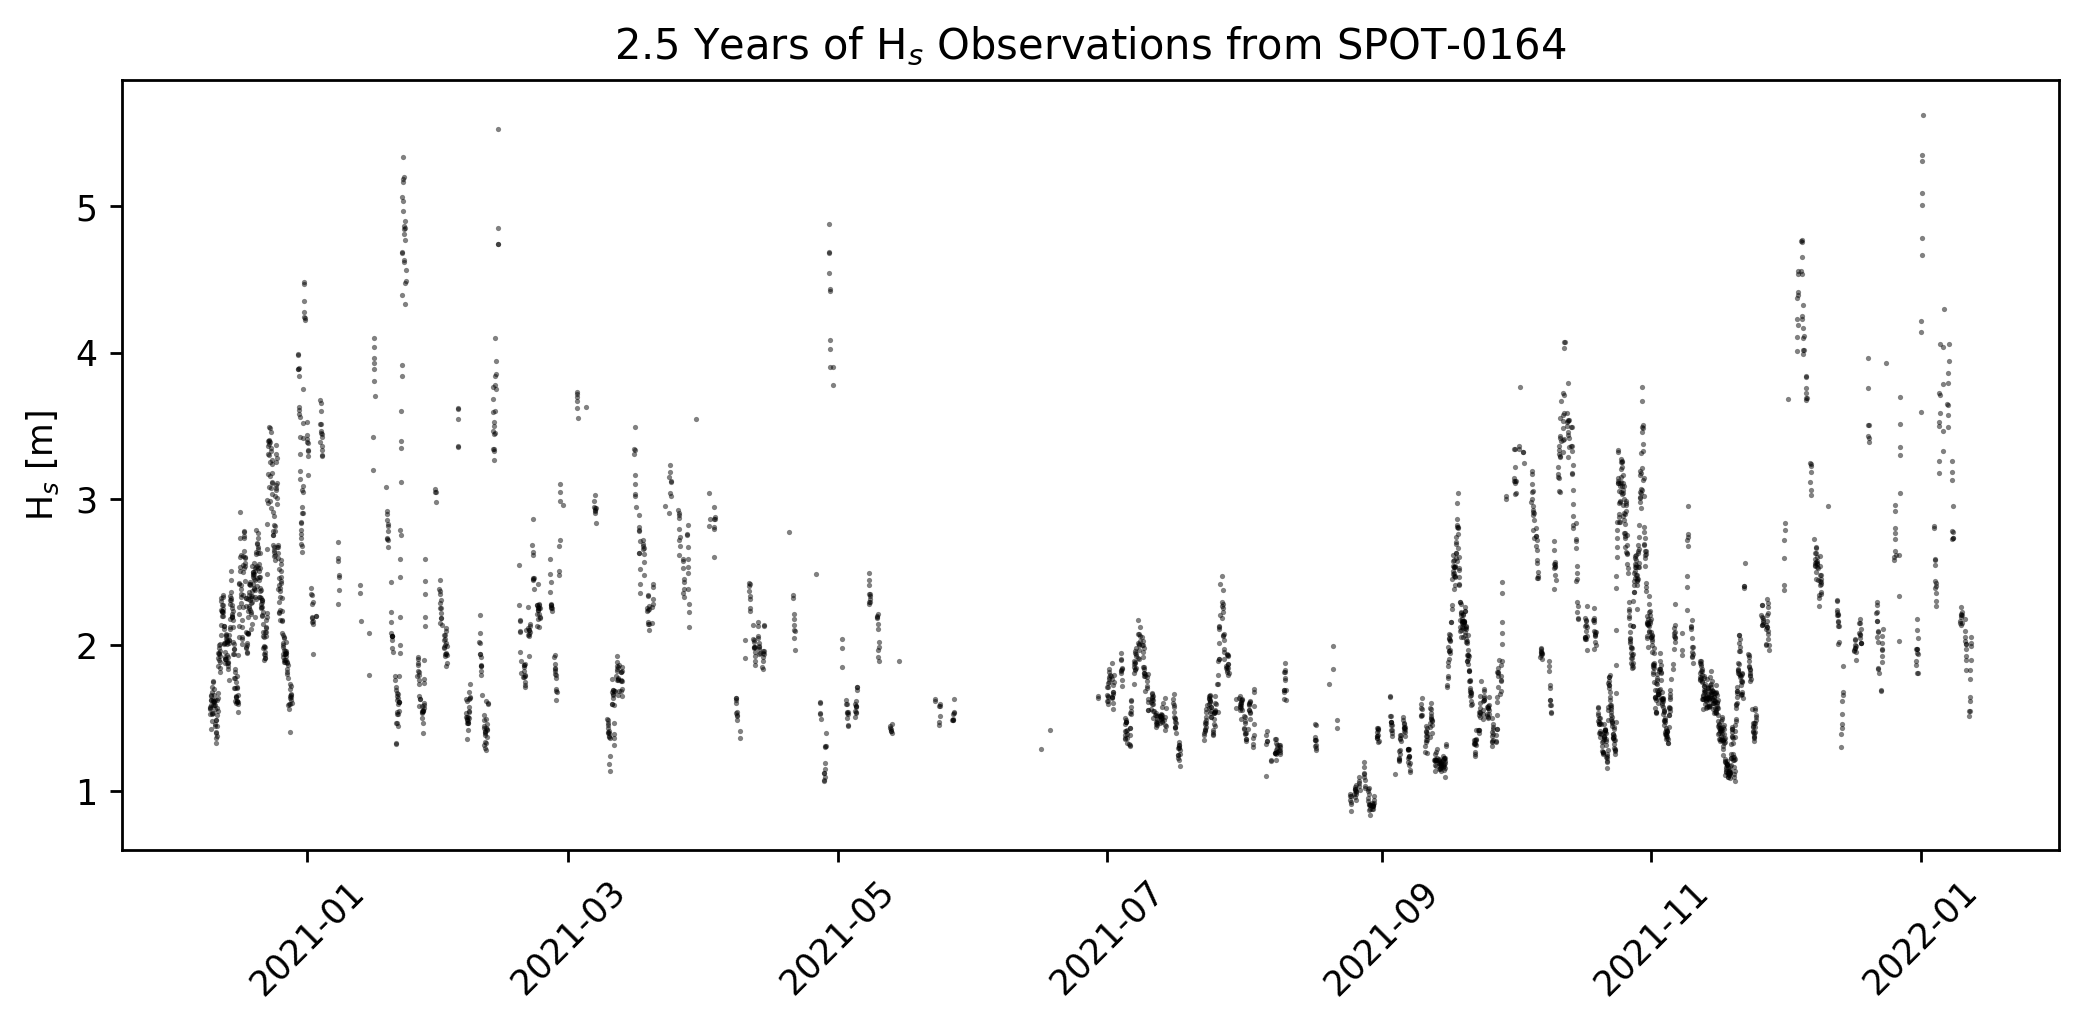

In [5]:
selected_ds = ds.sel(index=sli)

fig, ax = plt.subplots(1,1, figsize=(10,4), dpi=250)
ax.scatter(selected_ds.time[sli], selected_ds.significant_waveheight[sli], c='k',alpha=0.5, marker='.', s=1)
plt.xticks(rotation=45)
plt.ylabel('H$_s$ [m]')
plt.title(f"2.5 Years of H$_s$ Observations from {spotter_id}")
plt.show()